# Projections and Investor Insights | Zillow dataset

**Author: Miguel Santana | Flatiron Review: 11/4/2020, 1 PM**

# Methodology
A real-estate firm is looking for investment opportunities in the state of Colorado. As a consultant, I am tasked with reviewing real estate data found on Zillow's research [page](https://www.zillow.com/research/data/) and providing insight and recommendations to corporate stakeholders. Investment recommendations will be given respective of market volatility, risk, profit and return on investment. Time series modeling will be used to identify and relay the top 5 Zip Codes for real-estate investment over the next two years.  

## Framework
The OSEMN framework will be used to navigate the project, models and interpretations culminating in actionable business recommendations. 

The OSEMN Framework

* **Obtain**  
* **Scrub**
* **Explore** 
* **Model** 
* **INterpret** 

### Loading Libraries

In [1]:
# Import Libraries/Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import Image
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Statsmodels/Time Series/Modeling Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # see classical method of determin p,q orders
import pmdarima as pm # autoarima
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Obtain
## Importing Data

In [3]:
data = pd.read_csv('zillow_data.csv')

In [4]:
# Initial data observations
print(data.shape)
data.head()

(14723, 272)


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,...,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,...,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,...,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,...,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,...,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Scrub 
## Preprocessing

### ZipCode | Rename & Index

In [5]:
# Addressing Zipcode Column
data.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

### Specifying Dataset Zip Codes

In [6]:
# Separating out Zip Codes in Denver
df = data[(data['State'] == 'CO')]
print(df.shape)
print('\n')
print(f'There are {df.ZipCode.nunique()} Zip Codes in Colorado.')

(249, 272)


There are 249 Zip Codes in Colorado.


In [7]:
data = df.copy()

### Relevant Time Values | Post 08' Housing Crisis

In [8]:
# Retaining data after 2008 housing crisis
df = df.drop(df.loc[:, '1996-04':'2008-12'].columns, axis = 1) 

### Transforming | Wide to Long Format

In [9]:
# Transforming data and dropping null values
df = pd.melt(df, 
             id_vars=['RegionID', 'ZipCode', 'City', 'State', 'Metro', 
                      'CountyName', 'SizeRank'], var_name='Date', 
             value_name='Property Value')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
# Dropping resulting nulls from melt
df = df.dropna(subset=['Property Value'])
print(df.shape)
df.head()

(27840, 8)


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Property Value
Date,,,,,,,,
2009-01-01,93263,80134,Parker,CO,Denver,Douglas,121,311000.0
2009-01-01,93203,80013,Aurora,CO,Denver,Arapahoe,130,181200.0
2009-01-01,93490,80634,Greeley,CO,Greeley,Weld,250,175800.0
2009-01-01,93205,80015,Aurora,CO,Denver,Arapahoe,301,230100.0
2009-01-01,93449,80525,Fort Collins,CO,Fort Collins,Larimer,312,254600.0


### Time Series Tranform

In [10]:
# Full dataset observations
ts = df.groupby('Date').aggregate({'Property Value':'mean'})
ts.head()

,Property Value
Date,
2009-01-01,279180.645161
2009-02-01,278313.306452
2009-03-01,277252.016129
2009-04-01,276025.806452
2009-05-01,274431.854839


# Exploratory Data Analysis

## Observing Full Dataset Trends

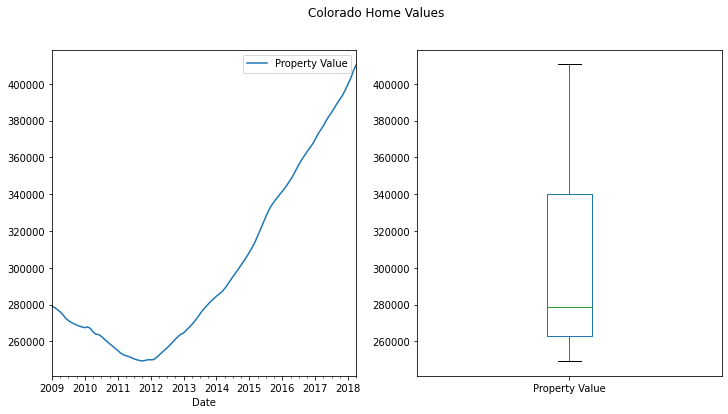

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
# ts.plot(ax = axes[0],title='Denver Home Values')
ts.plot(ax = axes[0])
ts.boxplot(ax = axes[1],grid=False);
fig.suptitle('Colorado Home Values')
plt.show()

<div class="alert alert-block alert-info">

**Observations:**
* Colorado's housing market has been at an increase since late 2011. 
* Colorado's property value is relatively normal with most values sitting between 280,000 and 340,000 dollars. The maximum value is just over 400,000 which is an excellent range for initial investment cost.

</div>

### ETS Decomposition

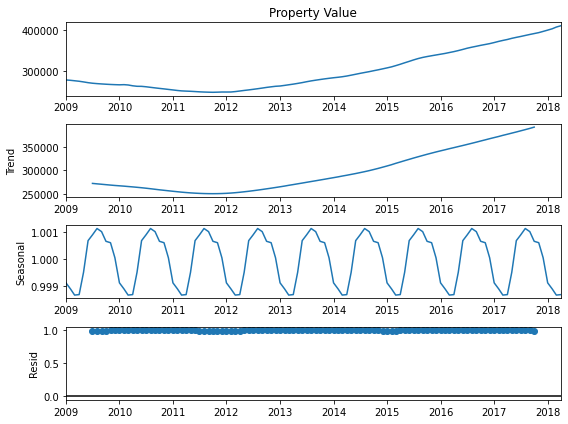

In [12]:
# Checking Trend, Seasonality and Residuals(Noise)
plt.rcParams.update({'figure.figsize': (8,6), 'figure.dpi':72})
CO = seasonal_decompose(ts['Property Value'], model='multiplicative')  # model='mul' also works
CO.plot();

<div class="alert alert-block alert-info">

It looks like there is quite a bit of seasonality occurring in the dataset. Once we narrow down our Zip Codes we will need to difference the data until we confirm stationarity. This can be done using the augmented dickey-fuller test.

</div>

### 2 Year Rolling Investment Period

In [13]:
# Calculating 2 year investment period (percent)
ts_2y = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
ts_2y.dropna(inplace=True)

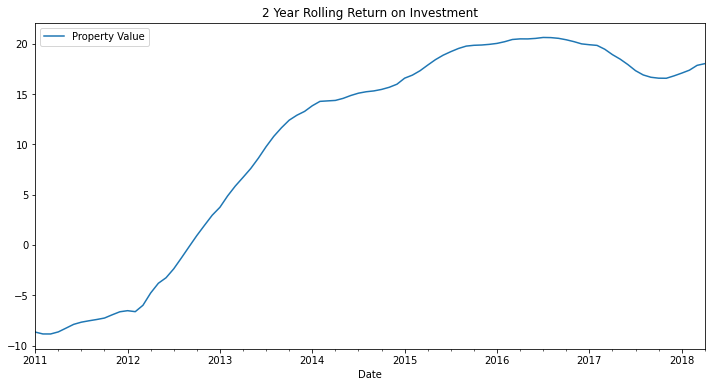

In [14]:
ts_2y.plot(figsize=(12,6),title='2 Year Rolling Return on Investment');

<div class="alert alert-block alert-info">

As expected the two year rolling return on investment is positive starting in early 2011. While there is a slight drop in return on investment between 2017 and 2018, the 2 year rolling return on investment stays above 15%. The dip may be due to outliers but ultimately these trends will be revealed as we identify Zip Code features individually.

</div>

## Zip Code Selection

In [15]:
# Original denver dataframe
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
120,93263,80134,Parker,CO,Denver,Douglas,121,193700.0,193500.0,193400.0,193400.0,193700.0,194100.0,194600.0,195300.0,196000.0,196700.0,197300.0,197800.0,198100.0,198300.0,198300.0,198400.0,198500.0,198700.0,...,420800,423400,426300,428700,430200,431200,432300,434300,437300,440400,442300,443900,446400,448700,449700,451300,454400,458700,462400,465100,468000,471500,473900,476100,477200
129,93203,80013,Aurora,CO,Denver,Arapahoe,130,123600.0,123700.0,123700.0,123800.0,123900.0,124000.0,124100.0,124300.0,124600.0,125100.0,125600.0,126000.0,126400.0,126900.0,127400.0,128000.0,128600.0,129200.0,...,280200,282800,285100,287200,289000,290900,292800,294900,297200,300300,304000,307300,309400,311100,313000,314800,317100,319500,322100,325600,329600,332600,335600,339000,341300
249,93490,80634,Greeley,CO,Greeley,Weld,250,135100.0,134700.0,133900.0,132800.0,131500.0,129900.0,128300.0,126400.0,124600.0,122900.0,121300.0,119800.0,118800.0,118500.0,118800.0,119500.0,120600.0,122000.0,...,247100,249300,251800,254800,257500,260100,262800,265000,266900,269300,271300,273100,275200,277200,278900,281300,283500,285100,286900,289300,291800,294200,296700,299400,301100
300,93205,80015,Aurora,CO,Denver,Arapahoe,301,158900.0,158700.0,158400.0,158200.0,157900.0,157700.0,157700.0,157700.0,157900.0,158300.0,158800.0,159200.0,159700.0,160400.0,161000.0,161800.0,162600.0,163400.0,...,341700,345000,347700,350000,352300,354500,356400,358000,360100,363800,368000,370900,372800,374400,375800,376700,378500,380800,383400,386600,390300,393400,396100,399500,401800
311,93449,80525,Fort Collins,CO,Fort Collins,Larimer,312,157500.0,157900.0,158100.0,158100.0,158000.0,157800.0,157500.0,156900.0,156300.0,155700.0,155000.0,154200.0,153900.0,154100.0,154900.0,155900.0,156900.0,157600.0,...,358000,361600,365200,368700,371200,372700,373300,374100,375600,378300,381700,385000,387900,390800,392900,394200,395100,395800,396700,398000,400100,402700,405000,407200,408900


In [16]:
# Function to tranform/melt each zip code
def transform(df):
    '''Transforms data from wide to long format/sets datetime as index'''
    transformed = pd.melt(df, 
                          id_vars=['RegionID', 'ZipCode', 'City', 'State', 
                                   'Metro', 'CountyName', 'SizeRank'], 
                          var_name='Date', value_name='Property Value')
    
    transformed['Date'] = pd.to_datetime(transformed['Date'], infer_datetime_format=True)
    transformed = transformed.dropna(subset=['Property Value'])
    return transformed # .groupby('Date').aggregate({'Property Value':'mean'})

In [17]:
# Dictionary for Zip Codes
denver_ts_dict = {}

for z in data.ZipCode.unique(): # iterate through zip codes
    startdf = data[data.ZipCode == z] # each zip code
    start_ts = transform(startdf) # time series (melt) per zip code
    start_ts2 = start_ts.groupby('Date').aggregate({'Property Value':'mean'})
    denver_ts_dict[z] = start_ts2 # adding to dictionary

In [18]:
# Dictionary of dataframes | keys(zipcodes)
# denver_ts_dict.keys()

### 2 Year Rolling Investment Period (Per Zip Code)

In [19]:
# Calculating the 2 year rolling ROI per zipcode in dictionary of dataframes
R2ROI = {}
for i, key in enumerate(denver_ts_dict):
    denver = (denver_ts_dict[key] - denver_ts_dict[key].shift(periods=24))/denver_ts_dict[key].shift(periods=24)*100
    denver.dropna(inplace=True)
    R2ROI[list(denver_ts_dict.keys())[i-1]] = denver

In [20]:
# R2ROI[80219].head()

In [21]:
 # filter only 15 highest current return zipcodes
M12_R2ROI = {}
for i, key in enumerate(R2ROI):
    M12_R2ROI[list(R2ROI.keys())[i-1]] = R2ROI[key].iloc[-13:-1].values.mean() # 12 month mean of rolling means
    # from_dict keys-columns | orient new key-row
    R12R2 = pd.DataFrame.from_dict(M12_R2ROI, orient='index', columns=['12 Month Mean (R2M)'])
    R12R2 = R12R2.nlargest(5, ['12 Month Mean (R2M)']) # 5 Largest Values
#     R12R2 = pd.DataFrame(R12R2) #from array to dataframe format again
#     R12R2 = R12R2.transpose()

In [22]:
R12R2

,12 Month Mean (R2M)
81003,43.655790
81520,39.389149
80916,38.961456
81635,38.564148
80921,37.349697


<div class="alert alert-block alert-info">

Selection was completed by averaging the last 12 monthly ROI values (2 year rolling ROI) and filtering for the 5 largest values.

Zip Codes Selected:
* 81003
* 81520
* 80916
* 81635
* 80921

</div>

## Top 5 Zip Codes

In [23]:
top5 = [81003,81520,80916,81635,80921]
df = data[(data.ZipCode.isin(top5))]

### Relevant Time Values | Last 10 Years

In [24]:
# Dropping data time data
df = df.drop(df.loc[:, '1996-04':'2008-06'].columns, axis = 1) 

In [25]:
# Transform/melt dataset
df = transform(df)

In [26]:
# Datetime/set index/frequency
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
# Dropping resulting nulls from melt
df = df.dropna(subset=['Property Value'])
print(df.shape)
df.head()

(590, 8)


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Property Value
Date,,,,,,,,
2008-07-01,93594,80916,Colorado Springs,CO,Colorado Springs,El Paso,2140,143400.0
2008-07-01,93599,80921,Colorado Springs,CO,Colorado Springs,El Paso,5645,357900.0
2008-07-01,93805,81520,Clifton,CO,Grand Junction,Mesa,7010,181300.0
2008-07-01,93631,81003,Pueblo,CO,Pueblo,Pueblo,7053,74400.0
2008-07-01,93829,81635,Parachute,CO,Glenwood Springs,Garfield,9998,273200.0


In [27]:
df = df[['ZipCode','Property Value']]
df.rename({'Property Value': 'Property_Value'}, axis='columns', inplace=True)
df['ZipCode'] = df['ZipCode'].astype('category')

In [28]:
differencing = df.copy()

In [29]:
# Time Series Per Zip Code
# List containing the 5 different time series.
df_ts = []
for z in top5:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df2 = df[df['ZipCode']==z].asfreq('MS')
    df_ts.append(df2)
print('\nZipCode Time Series:')
df_ts[0].head()


ZipCode Time Series:


,ZipCode,Property_Value
Date,,
2008-07-01,81003,74400.0
2008-08-01,81003,73700.0
2008-09-01,81003,73400.0
2008-10-01,81003,73000.0
2008-11-01,81003,72600.0


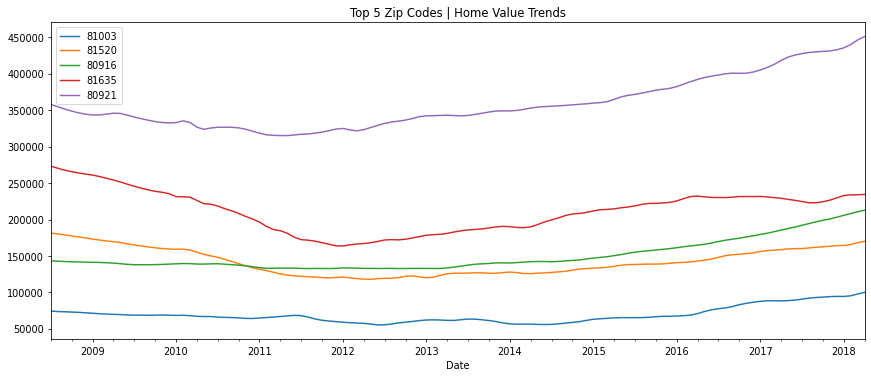

In [30]:
plt.rcParams.update({'figure.figsize': (10,10), 'figure.dpi':70})
# General trend data
for i in range(5):
    df_ts[i].Property_Value.plot(label=df_ts[i].ZipCode[0],figsize=(15,6),title='Top 5 Zip Codes | Home Value Trends')

    plt.legend()

## Augmented Dickey-Fuller Test (Stationarity Test)

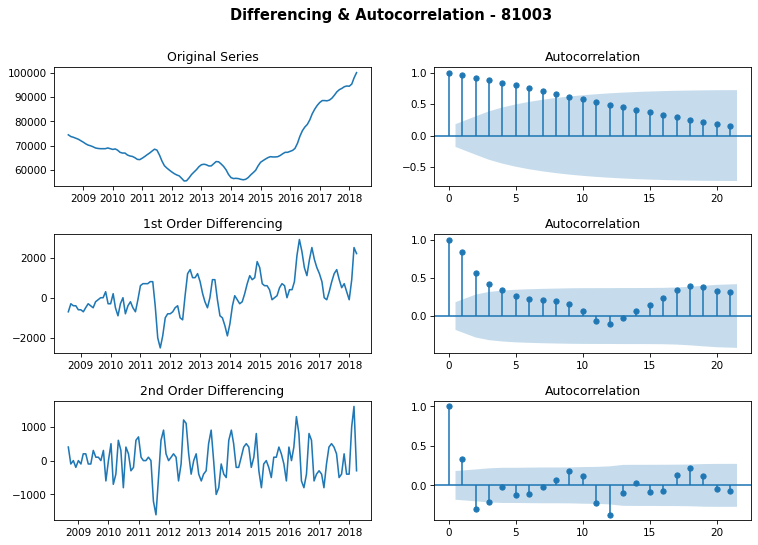

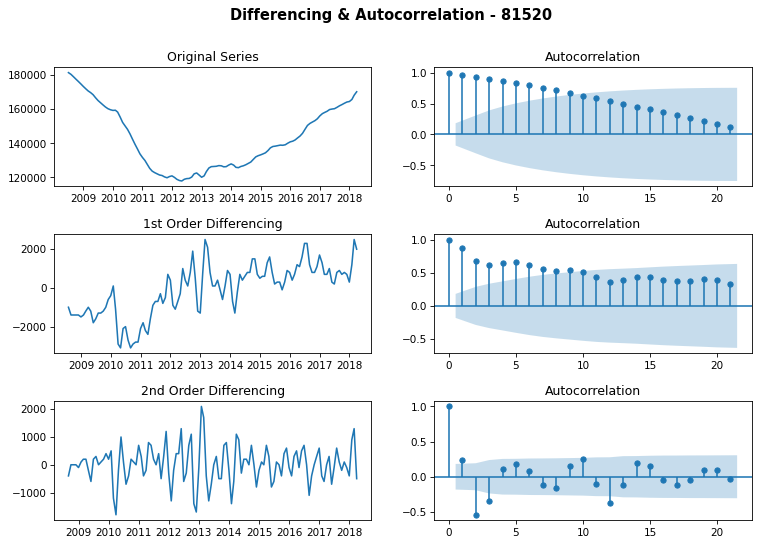

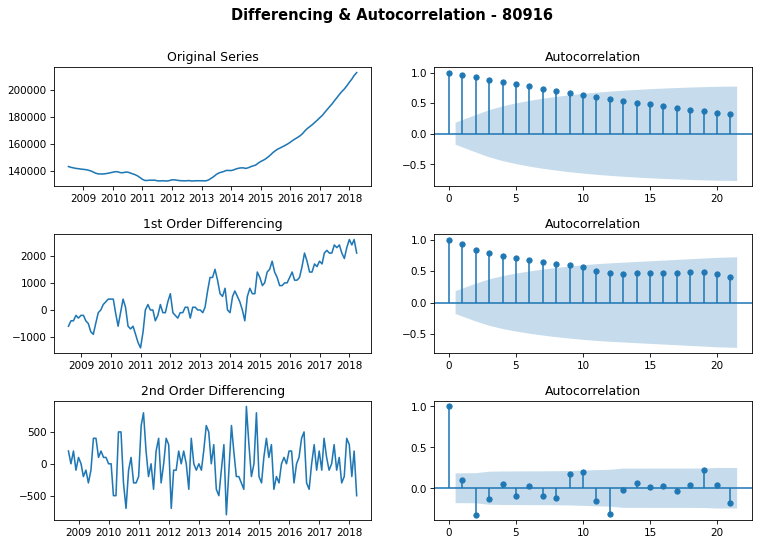

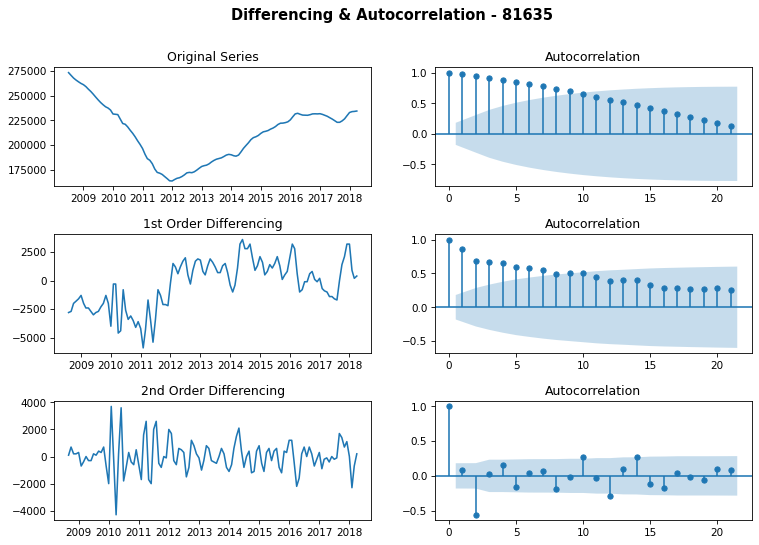

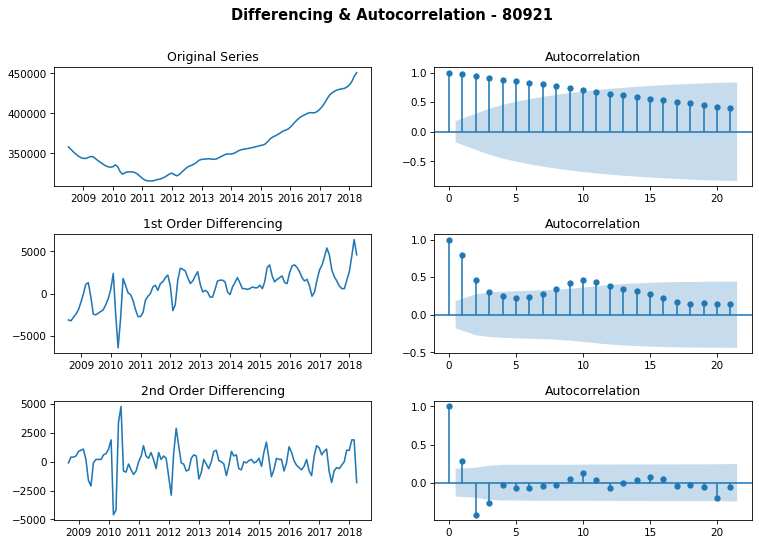

In [31]:
plt.rcParams.update({'figure.figsize': (12,8), 'figure.dpi':75})
# z = list(df_ts[i].ZipCode.unique())

for i in range(5):
    df_z = df_ts[i]
    fig, axes = plt.subplots(3,2)
    axes[0, 0].plot(df_z.Property_Value); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(df_z.Property_Value, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(df_z.Property_Value.diff()); axes[1, 0].set_title('1st Order Differencing',fontsize=12)
    plot_acf(df_z.Property_Value.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df_z.Property_Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(df_z.Property_Value.diff().diff().dropna(), ax=axes[2, 1])
    
    fig.suptitle(f'Differencing & Autocorrelation - {df_ts[i].ZipCode[0]}', fontsize=14, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4)
    plt.show()

<div class="alert alert-block alert-info">

It looks like stationarity is achieved after differencing twice. Based on the autocorrelation plot we will need to address seasonality. Lets confirm with the Augmented Dickey-Fuller Test.
    
</div>

In [32]:
for i in range(5):
    results = adfuller(df_ts[i].Property_Value.diff().diff().dropna())
    print(f'ADF test (2d) p-value for zipcode: {df_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADF test (2d) p-value for zipcode: 81003
p-value: 1.0792555536512186e-05
Reject the null hypothesis. Data is stationary.

ADF test (2d) p-value for zipcode: 81520
p-value: 0.0019620492495947533
Reject the null hypothesis. Data is stationary.

ADF test (2d) p-value for zipcode: 80916
p-value: 0.00014653069856000668
Reject the null hypothesis. Data is stationary.

ADF test (2d) p-value for zipcode: 81635
p-value: 3.010387766324595e-06
Reject the null hypothesis. Data is stationary.

ADF test (2d) p-value for zipcode: 80921
p-value: 3.100505095649278e-11
Reject the null hypothesis. Data is stationary.



<div class="alert alert-block alert-info">

Stationarity confirmed at a 'd' value of 2.
    
</div>

### Test/Train Split

In [33]:
# df_ts[4]

In [34]:
# Separating out dataframes / instantiating
zip81003 = df_ts[0].Property_Value
# Test/Train Split
train81003 = zip81003.iloc[:95] # up to not inc 95 
test81003 = zip81003.iloc[94:] # after 93

In [35]:
# Separating out dataframes / instantiating
zip81520 = df_ts[1].Property_Value
# Test/Train Split
train81520 = zip81520.iloc[:95] # up to not inc 95 
test81520 = zip81520.iloc[94:] # after 93

In [36]:
# Separating out dataframes / instantiating
zip80916 = df_ts[2].Property_Value
# Test/Train Split
train80916 = zip80916.iloc[:95] # up to not inc 94 
test80916 = zip80916.iloc[94:] # after 93

In [37]:
# Separating out dataframes / instantiating
zip81635 = df_ts[3].Property_Value
train81635 = zip81635.iloc[:95] # up to not inc 95 
test81635 = zip81635.iloc[94:] # after 93

In [38]:
# Separating out dataframes / instantiating
zip80921 = df_ts[4].Property_Value
train80921 = zip80921.iloc[:95] # up to not inc 95 
test80921 = zip80921.iloc[94:] # after 93

### Auto Arima | Parameter Selection

In [39]:
# Grid search function
def parameters(ts):
    '''Using a grid search function to find the best parameters for modeling'''
    stepwise_fit = pm.auto_arima(ts, start_p=1, start_q=1, test='adf', max_p=10, 
                                 max_q=10, m=12, seasonal=True, d=2, D=1, 
                                 stepwise=True, suppress_warnings=True, trend='ct', 
                                 trace=False, error_action='ignore')
   
    return stepwise_fit.order, stepwise_fit.seasonal_order

In [40]:
# # Saving parameter values for modeling
params81003 = parameters(train81003)
params81520 = parameters(train81520)
params80916 = parameters(train80916)
params81635 = parameters(train81635)
params80921 = parameters(train80921)

# SARIMAX Modeling

In [41]:
def sarima_model(ts, ordervals, s_ordervals):
    '''Function to process a SARIMAX model'''
    model = SARIMAX(ts, order=ordervals, seasonal_order=s_ordervals, trend='ct', 
                    enforce_stationarity=True, enforce_invertibility=False)
    output = model.fit()
    return output

In [42]:
def predict_vals(train, test, results):
    '''Returns predicted values using the model results'''
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = results.predict(start=start, end=end, dynamic=True, typ='levels').rename('SARIMAX Predictions')
    return predictions

In [43]:
def ratio(train, test, predictions):
    '''Calculate the RMSE to mean ratio and returns model validation stats.'''
    rmse_error = rmse(test, predictions)
    mean = train.mean()
    ratio = rmse_error/mean
    print(f'RSME: {rmse_error}')
    print(f'RMSE-to-Mean ratio is: {ratio}')
#     return ratio

In [44]:
def plot_proj_forecast(ts, model_output, plot=True):
    '''Calculate predicted, forecasted values and return dataframe with values.'''
    # Get forecast and confidence interval for steps ahead in future
    forecast = model_output.predict(len(ts),len(ts)+23,typ='levels').rename('SARIMA Forecast')
    future = model_output.get_forecast(steps=24, dynamic=True)
    future_conf = future.conf_int()

    # plot results
    ax = ts['2014':].plot(label='Observed', figsize=(12, 8))
    future.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(future_conf.index, future_conf.iloc[:, 0], future_conf.iloc[:, 1], 
                    color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # show prediction for end of step-period (in this case in 2 years future time)
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    predictions = {}
    predictions['forecast'] = forecast
    predictions['maximum'] = maximum
    predictions['minimum'] = minimum
    
    predictions = pd.DataFrame.from_dict(predictions, orient='index', columns=['Zip Code'])
    return predictions

## Zip Code 81003

### Modeling Training Data

In [45]:
print(f'Gridsearch best modeling parameters for ZipCode 81003 are:{params81003}') 

Gridsearch best modeling parameters for ZipCode 81003 are:((0, 2, 0), (0, 1, 0, 12))


In [46]:
# Fitting train data / testing against test
results = sarima_model(train81003,(2,2,0),(2,0,2,12)) # Fit Model
predictions = predict_vals(train81003, test81003, results) # Validate/Predictions
ratio(train81003, test81003, predictions) # Check Predictions

RSME: 6774.706457350693
RMSE-to-Mean ratio is: 0.10536608386240068


<div class="alert alert-block alert-info">

**The error-to-mean ratio is just over 10% and within an acceptable range. Time to fit the model to the full Zip Code dataset to make predictions.**

</div>

### Modeling Full Zip Code Dataset

In [47]:
# Fitting full data
output81003 = sarima_model(zip81003,(2,2,0),(2,0,2,12))
output81003.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                          Property_Value   No. Observations:                  118
Model:             SARIMAX(2, 2, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -886.978
Date:                                 Wed, 11 Nov 2020   AIC                           1791.956
Time:                                         00:10:44   BIC                           1816.738
Sample:                                     07-01-2008   HQIC                          1802.016
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9366    275.813      0.032      0.974    -531.646     549.519
drift          0.5867      3.292      0.178      0.859      -5.866       7.039
ar.L1          0.0422      0.022      1.881      0.060      -0.002       0.086
ar.L2         -0.0486      0.029     -1.683      0.092      -0.105       0.008
ar.S.L12      -1.2080      0.328     -3.678      0.000      -1.852      -0.564
ar.S.L24      -0.4953      0.414     -1.196      0.232      -1.307       0.316
ma.S.L12       1.1377      0.336      3.386      0.001       0.479       1.796
ma.S.L24       0.3771      0.441      0.855      0.392      -0.487       1.242
sigma2       1.87e+05   2.23e+04      8.369      0.000    1.43e+05    2.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.26   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.01   Prob(JB):                         0.34
Heteroskedasticity (H):               1.39   Skew:                             0.31
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

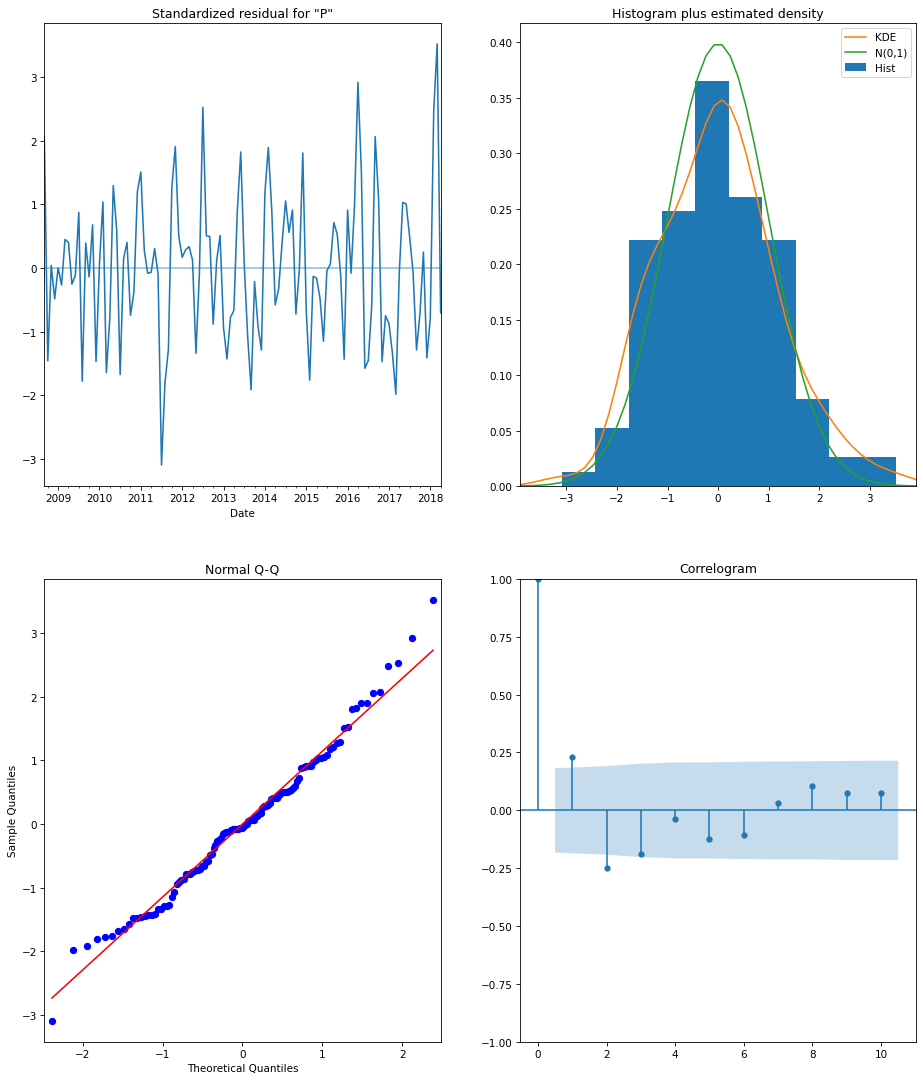

In [48]:
# Call plot_diagnostics() on the model results
output81003.plot_diagnostics(figsize=(15, 18))
plt.show()

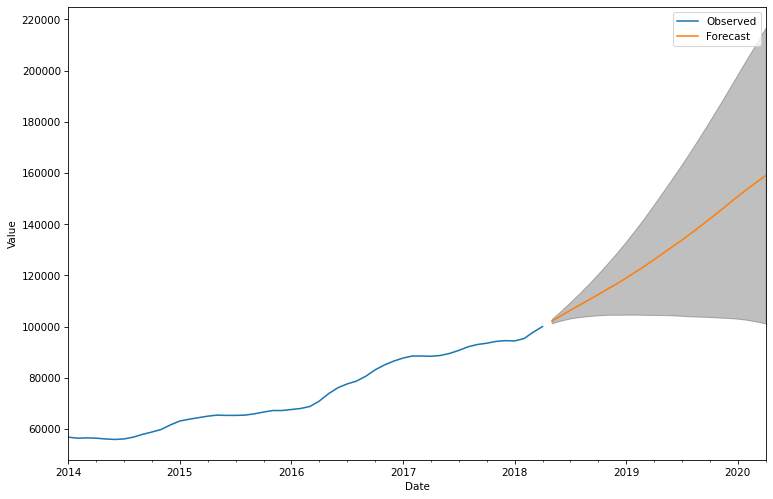

In [49]:
predictions = plot_proj_forecast(zip81003, output81003)

In [50]:
predictions = predictions.T

In [51]:
zip_code_81003 = predictions
zip_code_81003.rename({'Zip Code': '81003'}, inplace=True)

<div class="alert alert-block alert-info">

**The AIC value is 1791. The stationarity condition is met and the residuals look normally distributed. Forecast values look great for investment and the minimum and maximum values have been saved for further analysis.**

</div>

## Zip Code 81520

### Modeling Training Data

In [52]:
print(f'Gridsearch best modeling parameters for ZipCode 81520 are:{params81520}') 

Gridsearch best modeling parameters for ZipCode 81520 are:((0, 2, 0), (1, 1, 0, 12))


In [53]:
results = sarima_model(train81520,(0,2,0),(0,0,1,12)) # Fit Model
# results.summary()
predictions = predict_vals(train81520, test81520, results) # Validate/Predictions
ratio(train81520, test81520, predictions) # Check Predictions

RSME: 8738.06273542824
RMSE-to-Mean ratio is: 0.06304662215024896


<div class="alert alert-block alert-info">

**The error-to-mean ratio of 6.3% is below the 10% recommendation. Time to fit the model to the full Zip Code dataset to make predictions.**

</div>

### Modeling Full Zip Code Dataset

In [54]:
output81520 = sarima_model(zip81520,(0,2,0),(0,0,1,12))
output81520.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Property_Value   No. Observations:                  118
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -915.755
Date:                              Wed, 11 Nov 2020   AIC                           1839.509
Time:                                      00:10:46   BIC                           1850.524
Sample:                                  07-01-2008   HQIC                          1843.981
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.4882    146.371     -0.037      0.970    -292.370     281.394
drift          0.5169      2.302      0.225      0.822      -3.994       5.028
ma.S.L12      -0.0124      0.032     -0.388      0.698      -0.075       0.050
sigma2      4.244e+05   4.98e+04      8.518      0.000    3.27e+05    5.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.37   Jarque-Bera (JB):                 3.93
Prob(Q):                              0.01   Prob(JB):                         0.14
Heteroskedasticity (H):               0.95   Skew:                            -0.02
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

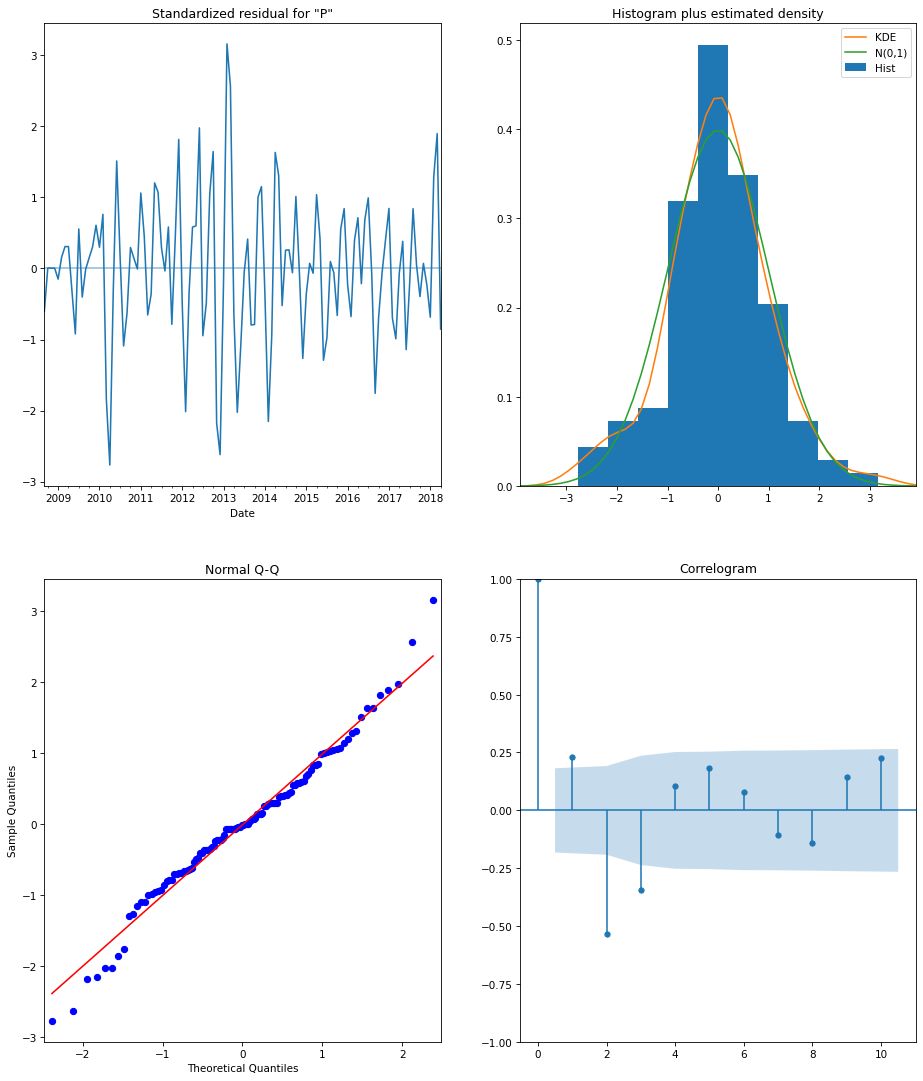

In [55]:
# Call plot_diagnostics() on the model results
output81520.plot_diagnostics(figsize=(15, 18))
plt.show()

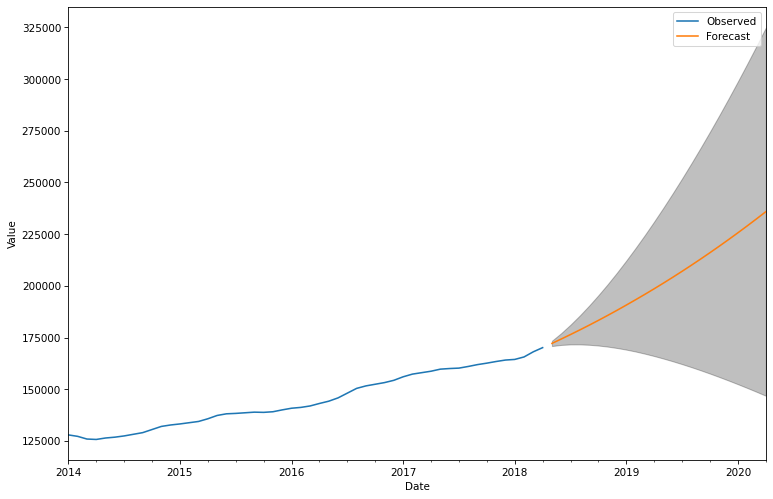

In [56]:
predictions = plot_proj_forecast(zip81520, output81520)

In [57]:
predictions = predictions.T

In [58]:
zip_code_81520 = predictions
zip_code_81520.rename({'Zip Code': '81520'}, inplace=True)

<div class="alert alert-block alert-info">

**The AIC value is 1839. The stationarity condition is met and the residuals look normally distributed. Forecast values look appropriate for investment and the minimum and maximum values have been saved for further analysis.**

</div>

## Zip Code 80916

### Modeling Training Data

In [59]:
print(f'Gridsearch best modeling parameters for ZipCode 80916 are:{params80916}') 

Gridsearch best modeling parameters for ZipCode 80916 are:((0, 2, 0), (1, 1, 0, 12))


In [60]:
results = sarima_model(train80916,(0,2,0),(2,0,1,12)) # Fit Model
# results.summary()
predictions = predict_vals(train80916,test80916,results) # Validate/Predictions
ratio(train80916, test80916, predictions) # Check Predictions

RSME: 4570.660032748679
RMSE-to-Mean ratio is: 0.0324194169686361


<div class="alert alert-block alert-info">

**The error-to-mean ratio of 3.2% is below the 10% recommendation. Time to fit the model to the full Zip Code dataset to make predictions.**

</div>

### Modeling Full Zip Code Dataset

In [61]:
output80916 = sarima_model(zip80916,(0,2,0),(2,0,1,12))
output80916.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Property_Value   No. Observations:                  118
Model:             SARIMAX(0, 2, 0)x(2, 0, [1], 12)   Log Likelihood                -831.302
Date:                              Wed, 11 Nov 2020   AIC                           1674.604
Time:                                      00:10:48   BIC                           1691.125
Sample:                                  07-01-2008   HQIC                          1681.311
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.0208     68.232      0.220      0.826    -118.711     148.752
drift          0.1414      1.031      0.137      0.891      -1.880       2.163
ar.S.L12       0.0027      1.271      0.002      0.998      -2.489       2.494
ar.S.L24       0.0393      0.068      0.574      0.566      -0.095       0.173
ma.S.L12      -0.0471      1.273     -0.037      0.970      -2.543       2.448
sigma2      1.035e+05   1.49e+04      6.927      0.000    7.42e+04    1.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.60   Prob(JB):                         0.74
Heteroskedasticity (H):               0.77   Skew:                             0.17
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

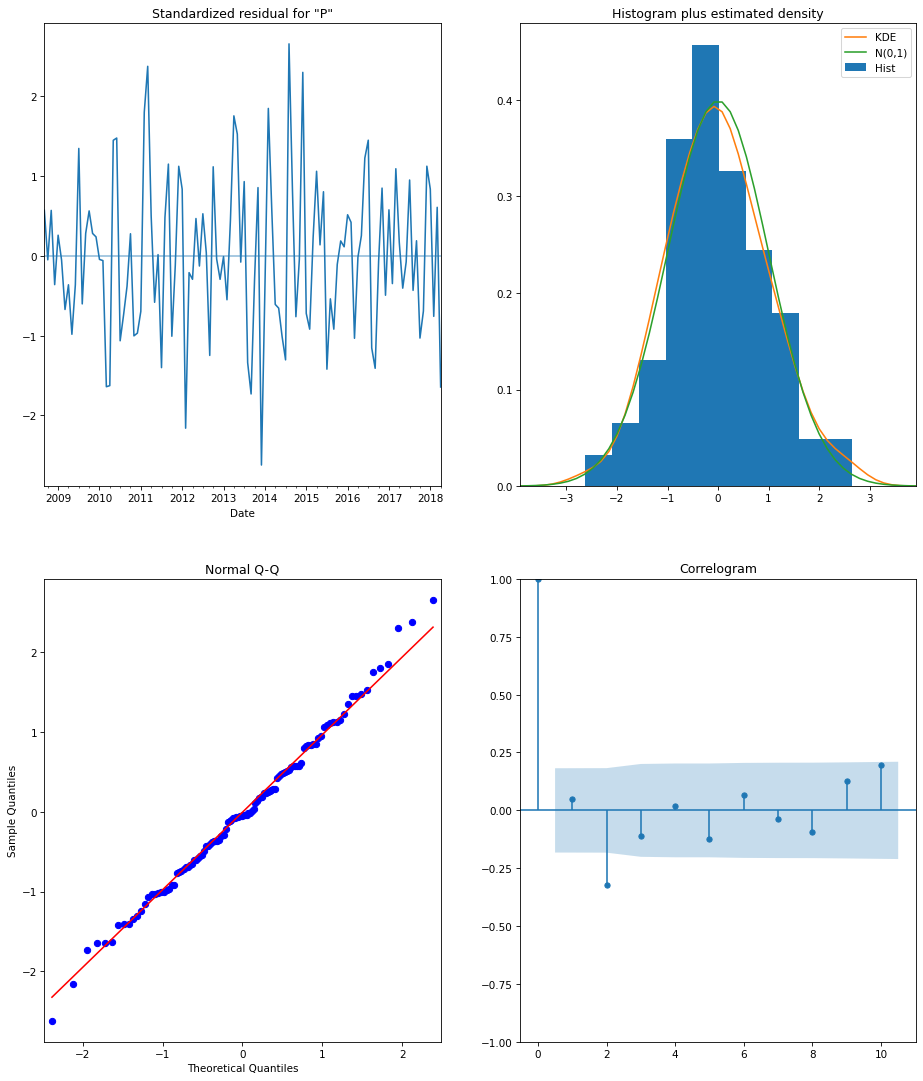

In [62]:
# Call plot_diagnostics() on the model results
output80916.plot_diagnostics(figsize=(15, 18))
plt.show()

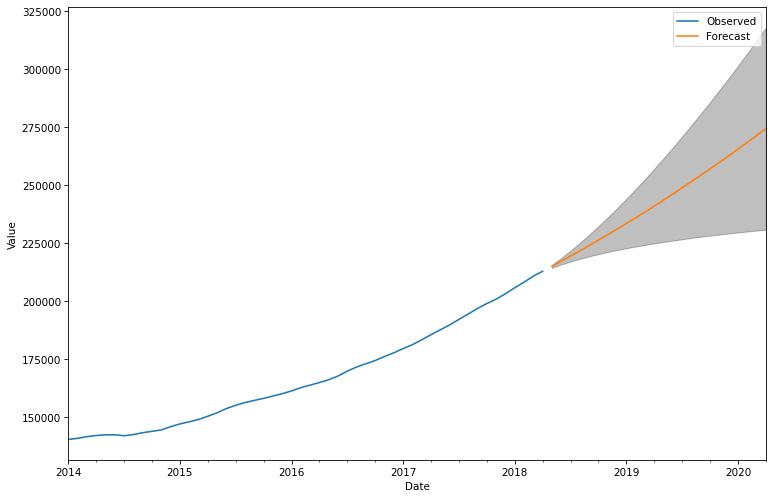

In [63]:
predictions = plot_proj_forecast(zip80916, output80916)

In [64]:
predictions = predictions.T

In [65]:
# Saving for final numbers
zip_code_80916 = predictions
zip_code_80916.rename({'Zip Code': '80916'}, inplace=True)

<div class="alert alert-block alert-info">

**The AIC value is 1674. The stationarity condition is met and the residuals look normally distributed. Forecast values are lower than the initial investment. The minimum and maximum values have been saved for further analysis.**

</div>

## Zip Code 81635

### Modeling Training Data

In [66]:
print(f'Gridsearch best modeling parameters for ZipCode 81635 are:{params81635}') 

Gridsearch best modeling parameters for ZipCode 81635 are:((0, 2, 0), (0, 1, 0, 12))


In [67]:
results = sarima_model(train81635,(2,2,1),(2,0,1,12)) # Fit Model
# results.summary()
predictions = predict_vals(train81635,test81635,results) # Validate/Predictions
ratio(train81635,test81635,predictions) # Check Predictions

RSME: 18606.455925100046
RMSE-to-Mean ratio is: 0.08961238791613246


<div class="alert alert-block alert-info">

**The error-to-mean ratio of 8.9% is below the 10% recommendation. Time to fit the model to the full Zip Code dataset to make predictions.**

</div>

### Modeling Full Zip Code Dataset

In [68]:
output81635 = sarima_model(zip81635,(2,2,1),(2,0,1,12))
output81635.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Property_Value   No. Observations:                  118
Model:             SARIMAX(2, 2, 1)x(2, 0, 1, 12)   Log Likelihood                -983.563
Date:                            Wed, 11 Nov 2020   AIC                           1985.126
Time:                                    00:10:51   BIC                           2009.908
Sample:                                07-01-2008   HQIC                          1995.186
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     61.9993    225.749      0.275      0.784    -380.461     504.460
drift         -0.6308      2.997     -0.211      0.833      -6.504       5.243
ar.L1          0.4320      1.314      0.329      0.742      -2.144       3.008
ar.L2         -0.0131      0.020     -0.670      0.503      -0.051       0.025
ma.L1         -0.4372      1.322     -0.331      0.741      -3.028       2.153
ar.S.L12      -0.7607      0.525     -1.449      0.147      -1.790       0.268
ar.S.L24       0.0060      0.024      0.250      0.803      -0.041       0.053
ma.S.L12       0.7585      0.527      1.439      0.150      -0.274       1.791
sigma2      8.347e+05   5.45e+04     15.315      0.000    7.28e+05    9.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                28.51
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

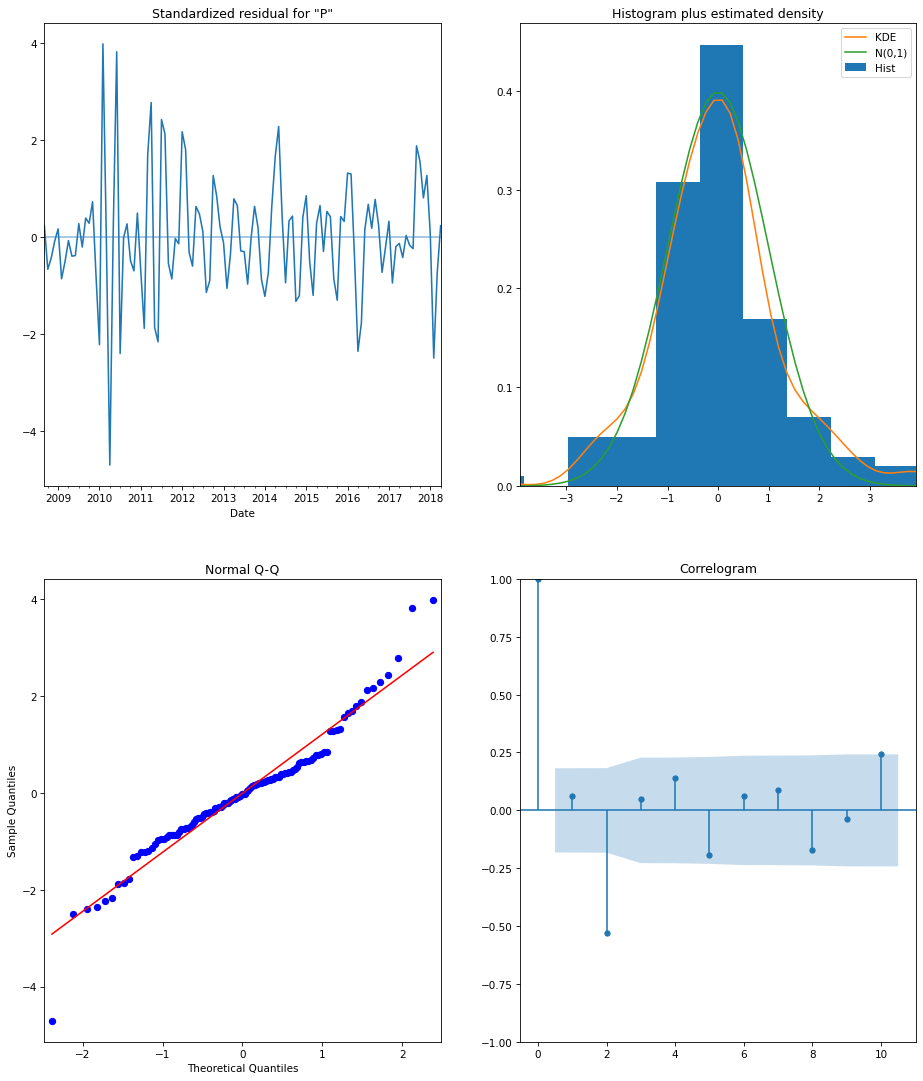

In [69]:
# Call plot_diagnostics() on the model results
output81635.plot_diagnostics(figsize=(15, 18))
plt.show()

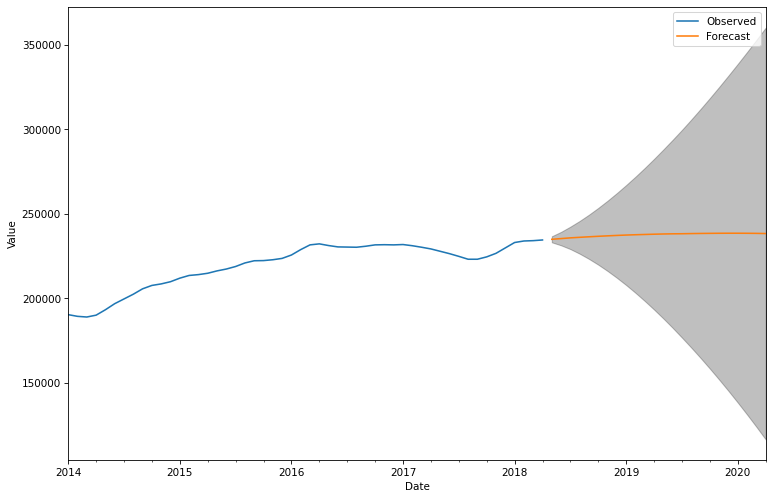

In [70]:
predictions = plot_proj_forecast(zip81635, output81635)

In [71]:
predictions = predictions.T

In [72]:
# Saving for final numbers
zip_code_81635 = predictions
zip_code_81635.rename({'Zip Code': '81635'}, inplace=True)

<div class="alert alert-block alert-info">

**The AIC value is 1985. The stationarity condition is met and the residuals look normally distributed. Forecast values are lower than the initial investment. Minimum and maximum values have been saved for further analysis.**

</div>

## Zip Code 80921

### Modeling Training Data

In [73]:
print(f'Gridsearch best modeling parameters for ZipCode 80921 are:{params80921}') 

Gridsearch best modeling parameters for ZipCode 80921 are:((0, 2, 0), (0, 1, 0, 12))


In [74]:
results = sarima_model(train80921,(1,2,2),(2,1,0,12)) # Fit Model
# results.summary()
predictions = predict_vals(train80921,test80921,results) # Validate/Predictions
ratio(train80921, test80921, predictions) # Check Predictions

RSME: 26736.307519515
RMSE-to-Mean ratio is: 0.07774180677879029


<div class="alert alert-block alert-info">

**The error-to-mean ratio of 7.7% is below the 10% recommendation. Time to fit the model to the full Zip Code dataset to make predictions.**

</div>

### Modeling Full Zip Code Dataset

In [75]:
output80921 = sarima_model(zip80921,(1,2,2),(2,1,0,12))
output80921.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      Property_Value   No. Observations:                  118
Model:             SARIMAX(1, 2, 2)x(2, 1, [], 12)   Log Likelihood                -924.749
Date:                             Wed, 11 Nov 2020   AIC                           1865.499
Time:                                     00:10:54   BIC                           1886.654
Sample:                                 07-01-2008   HQIC                          1874.069
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -81.3879    140.135     -0.581      0.561    -356.048     193.272
drift          0.9856      2.477      0.398      0.691      -3.869       5.841
ar.L1          0.6853      0.036     19.066      0.000       0.615       0.756
ma.L1         -1.4271      0.110    -12.950      0.000      -1.643      -1.211
ma.L2         -0.0152      0.059     -0.257      0.797      -0.132       0.101
ar.S.L12      -0.0079      0.025     -0.319      0.749      -0.056       0.041
ar.S.L24      -0.0036      0.014     -0.263      0.793      -0.030       0.023
sigma2      1.509e+06      0.013   1.15e+08      0.000    1.51e+06    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.99   Jarque-Bera (JB):                76.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.79e+23. Standard errors may be unstable.
"""

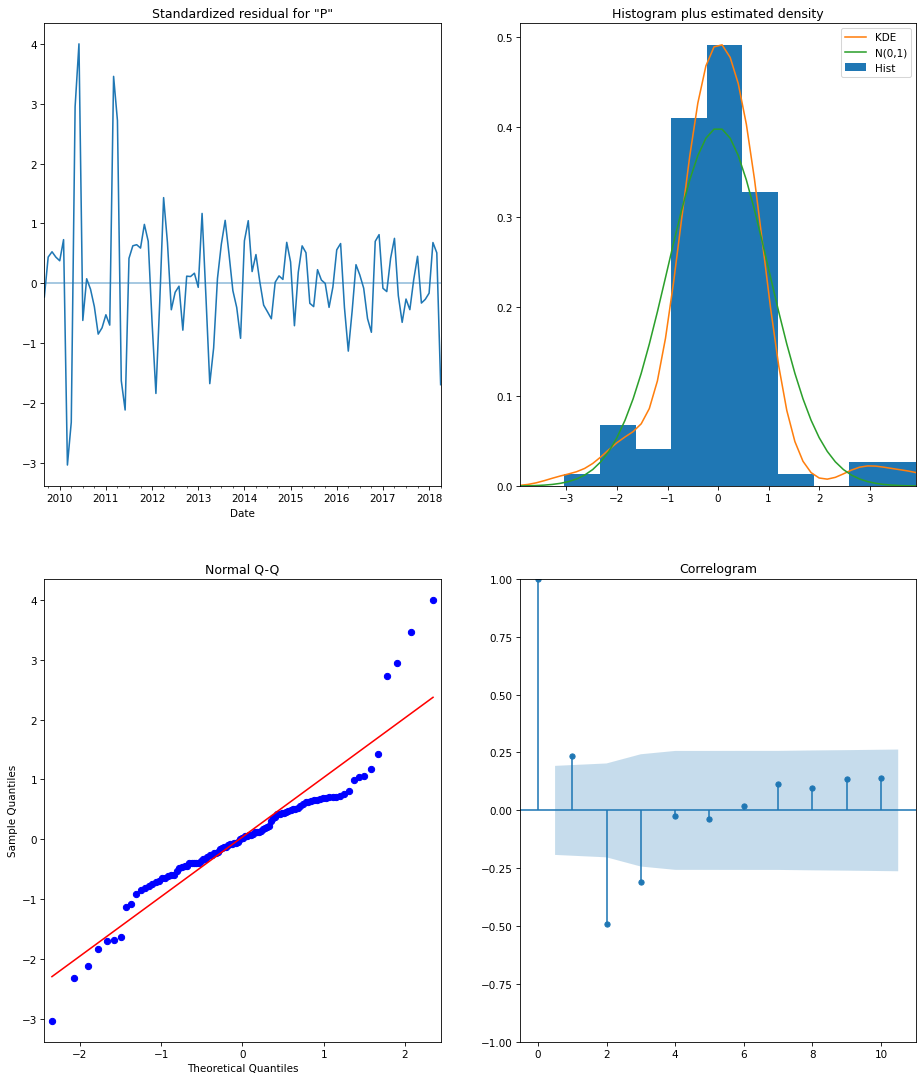

In [76]:
# Call plot_diagnostics() on the model results
output80921.plot_diagnostics(figsize=(15, 18))
plt.show()

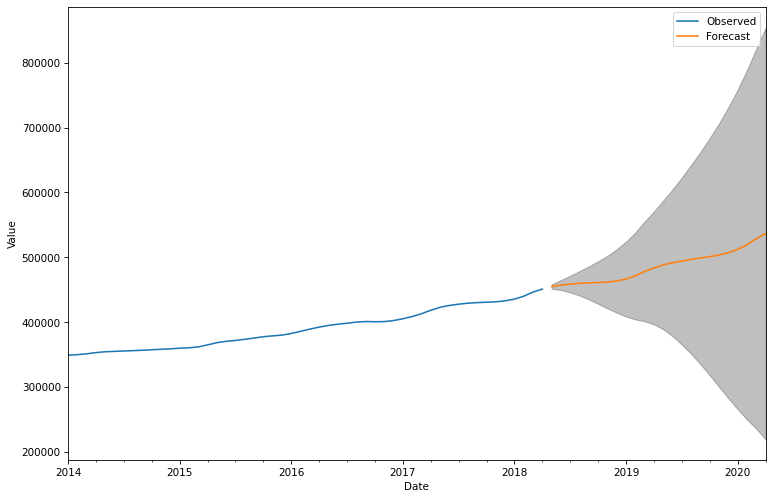

In [77]:
predictions = plot_proj_forecast(zip80921, output80921)

In [78]:
predictions = predictions.T

In [79]:
# Saving for final numbers
zip_code_80921 = predictions
zip_code_80921.rename({'Zip Code': '80921'}, inplace=True)

<div class="alert alert-block alert-info">

**The AIC value is 1865. The stationarity condition is met, residuals look normally distributed but I will note this model is the poorest of the five. Forecast values look appropriate for investment and the minimum and maximum values have been saved for further analysis.**

</div>

In [80]:
frames = [zip_code_80916,zip_code_80921,zip_code_81520,zip_code_81003,zip_code_81635]
df = pd.concat(frames)

In [81]:
df1 = differencing.tail()
df1 = df1.reset_index()
df1 = df1[['Property_Value']]

df = df.reset_index()
df = pd.concat([df, df1.reindex(df.index)], axis=1)
df = df.rename(columns={'index':'ZipCode', 'Property_Value':'Investment'})

In [82]:
df

,ZipCode,forecast,maximum,minimum,Investment
0,80916,274187.405390,317686.810768,230688.000012,212800.0
1,80921,536606.296243,854151.481130,219061.111356,451000.0
2,81520,235854.166985,324868.056936,146840.277033,170100.0
3,81003,159002.036474,216803.593743,101200.479204,100000.0
4,81635,238209.577273,360085.530731,116333.623815,234400.0


In [83]:
df['Min_ROI'] = df['minimum'] - df['Investment']
df['Max_ROI'] = df['maximum'] - df['Investment']
df['ROI'] = df['forecast'] - df['Investment']

In [84]:
pd.options.display.float_format = '{:.0f}'.format

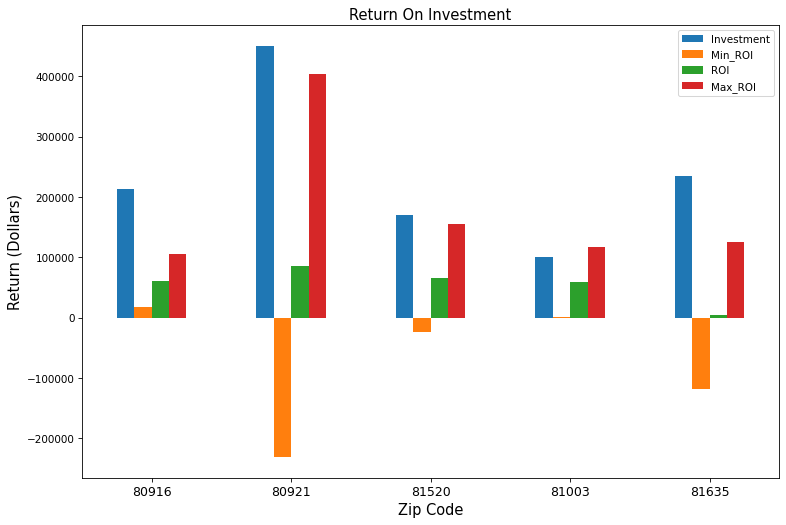

In [85]:
df['ZipCode'] = df['ZipCode'].astype('category')
df.set_index('ZipCode', inplace=True)
df = df[['Investment','Min_ROI','ROI','Max_ROI']]
ax = df.plot.bar()
for item in ax.get_xticklabels():
    item.set_rotation(0)
    item.set_size(12)
plt.title('Return On Investment', fontdict={'fontsize': 14})
plt.ylabel('Return (Dollars)', fontdict={'fontsize': 14})
plt.xlabel('Zip Code', fontdict={'fontsize': 14})
plt.show()
# plt.legend();

# Summary
Zillow's home value index dataset offers a variety of features and values for analysis. While enough to draw several conclusions, the data is too simple to provide granular predictions as real estate markets are effected by many outside factors. Factors such as proximity to amenities, commercial development and more recently COVID-19 can greatly effect the resale value of a home and ultimately an investors bottom line.

Zillow's dataset illustrates a ZVHI value index for Zip Codes across the United States. The values are representative of average housing prices per region. Through data exploration and feature engineering the top investment Zip Codes for Colorado were pulled for time series modeling.

**The method for selection included calculating 2 year rolling return on investment values per Zip Code. An average of the last 12 return on investment values was calculated and the 5 highest values were selected for analysis. This method allowed for a comprehensive assessment of return on investment with respect to the 2 year projection period we are looking to predict toward.**  

**Selected Zip Codes: 81003, 81520, 80916, 81635, 80921**

In [86]:
df

,Investment,Min_ROI,ROI,Max_ROI
ZipCode,,,,
80916,212800,17888,61387,104887
80921,451000,-231939,85606,403151
81520,170100,-23260,65754,154768
81003,100000,1200,59002,116804
81635,234400,-118066,3810,125686


<div class="alert alert-block alert-info">

# Results | Recommendations:

The top five zip codes to invest in are:

* 80916 - Colorado Springs, CO | Return on investment:
    * Minimum: 17,888 
    * Projected: 61,387
    * Maximum: 104,887
    
* 80921 - Colorado Springs, CO | Return on investment:
    * Minimum: -231,939 
    * Projected: 85,606
    * Maximum: 403,151
    
* 81520 - Clifton, CO | Return on investment:
    * Minimum: -23,260
    * Projected: 65,754
    * Maximum: 154,768
    
* 81003 - Pueblo, CO | Return on investment:
    * Minimum: 1,200
    * Projected: 59,002
    * Maximum: 116,804 
    
* 81635 - Parachute, CO | Return on investment:
    * Minimum: -118,006
    * Projected: 3,810
    * Maximum: 125,686


The Zip Codes that carries the highest recommendation are 81003 and 80916. They carry the smallest risk with the minimum projection still yielding a positive return on investment.

</div>

## Limitations
The final models were created using Zillow ZVHI values over the last 10 years. While this increased the predictive ability of the model, making 2 year projections using 10 years of data will lead to a certain level of inaccuracy. Additionally, it would be nice to be aware of additional factors that may influence these regions such as commercial development, federal poverty line data, etc. 

## Future Work
Future work should be completed using Zillow's additional datasets. Zillow offers census, economic and additional data that can be used to help build better models that offer additional insight.